# 30. Reading the result

In [ ]:
import stanza

_nlp = stanza.Pipeline(lang="en", processors="tokenize,pos,lemma")

_ALICE_FILE = "data/alice/alice.txt"
_OUTPUT_FILE = "data/alice_pos_tags.txt"

def _read_data(file_object, CHUNK_SIZE: int = -1) -> str:
    while True:
        data = file_object.read(CHUNK_SIZE)
        if not data:
            break
        yield data

_sentences = []

with open(_ALICE_FILE) as _input_file, open(_OUTPUT_FILE, "w") as _output_file:
    for data in _read_data(_input_file):
        doc = _nlp(data)
        for sentence in doc.sentences:
            for word in sentence.words:
                lower_lemma = word.lemma.lower()
                _output_file.write(f"{word.text} {lower_lemma} {word.pos} \n")
                _sentences.append({"text" : word.text, "lemma": lower_lemma, "pos"  : word.pos})
            _output_file.write(f"\n")

# 31. Verbs

In [3]:
def _find_items_by_pos(pos: str, wanted_item: str, items_list: list, sentences: list = _sentences) -> None:
    for word in sentences:
        if word["pos"] == pos:
            items_list.append(word[wanted_item])

_text_of_verbs = []  
_find_items_by_pos("VERB", "text", _text_of_verbs)

print(_text_of_verbs[:20])

['beginning', 'sitting', 'having', 'do', 'peeped', 'reading', 'had', 'thought', 'considering', 'made', 'feel', 'making', 'getting', 'picking', 'ran', 'was', 'think', 'hear', 'say', 'thought']


# 32. Base forms of verbs

In [4]:
_lemma_of_verbs = []              
_find_items_by_pos("VERB", "lemma", _lemma_of_verbs)

print(_lemma_of_verbs[:20])

['begin', 'sit', 'have', 'do', 'peep', 'read', 'have', 'think', 'consider', 'make', 'feel', 'make', 'get', 'pick', 'run', 'be', 'think', 'hear', 'say', 'think']


# 33. A of B

In [5]:
_a_of_b_list = [ ]

_NOUNS = ("NOUN", "PROPN")

for index in range(0, len(_sentences)-2):
    if (    _sentences[index  ]["pos"]   in _NOUNS
        and _sentences[index+1]["lemma"] == "of" 
        and _sentences[index+2]["pos"]   in _NOUNS):
        _a_of_b_list.append(f"{_sentences[index]['lemma']} {_sentences[index+1]['lemma']} {_sentences[index+2]['lemma']}")

print(_a_of_b_list[:30])

['plenty of time', 'saucer of milk', 'sort of way', 'heap of stick', 'row of lamp', 'book of rule', 'flavour of cherry', 'game of croquet', 'pool of tear', 'pair of boot', 'gallon of tear', 'pattering of foot', 'sort of thing', 'capital of paris', 'capital of rome', 'burst of tear', 'number of bathing', 'row of lodging', 'pool of tear', 'knowledge of history', 'subject of conversation', 'sort of thing', 'question of course', 'person of authority', 'earls of mercia', 'earl of mercia', 'archbishop of canterbury', 'sort of circle', 'deal of thought', 'chorus of voice']


# 34. A B

In [6]:
def _initialize_count() -> tuple:
    return [0, []]

def _update_max(current_max: tuple, new_value: tuple) -> tuple:
    return max([current_max, new_value], key=lambda item: item[0])

_max_noun_phrase = _initialize_count()
_current_noun_phrase = _initialize_count()

for word in _sentences:
    if word["pos"] in _NOUNS:
        _current_noun_phrase[0] += 1
        _current_noun_phrase[1].append(word["lemma"])
    else:
        _max_noun_phrase = _update_max(_max_noun_phrase, _current_noun_phrase)
        _current_noun_phrase = _initialize_count()

_max_noun_phrase = _update_max(_max_noun_phrase, _current_noun_phrase)
    
print(_max_noun_phrase[1])

['thing', 'mock', 'turtle', 'soup']


# 35. Frequency of words 

In [7]:
from collections import Counter

def _get_word_frequency(sentences: list = _sentences) -> Counter:
    frequence = Counter()
    for word in sentences:
        if word["pos"] not in ("SYM", "PUNCT"):
            frequence[word["lemma"]] += 1
    return frequence

_frequence = _get_word_frequency().most_common()

print(_frequence[:20])

[('the', 1643), ('be', 1076), ('and', 871), ('she', 796), ('to', 727), ('a', 685), ('i', 607), ('it', 588), ('say', 528), ('of', 514), ('you', 474), ('alice', 398), ('in', 365), ('not', 360), ('have', 336), ('that', 325), ('they', 291), ('do', 263), ('he', 260), ('as', 259)]


# 36. Top-ten frequent words

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def _get_freq_axis(word_frequence: list) -> list:
    x, y = [], []
    for word in word_frequence:
        x.append(word[0])
        y.append(word[1])
    return x, y

def _set_figure(title: str) -> None:
    fig, ax = plt.subplots(figsize=(9, 9))
    ax.set_ylabel("Occurrences")
    ax.set_title(title)
    print(type(ax))
    return ax
    
def _draw_bar(x: list, y: list, title: str) -> None:
    ax = _set_figure(title)
    ax.bar(x, y)
    ax.set_xlabel("Words")
    plt.show()

<class 'matplotlib.axes._subplots.AxesSubplot'>


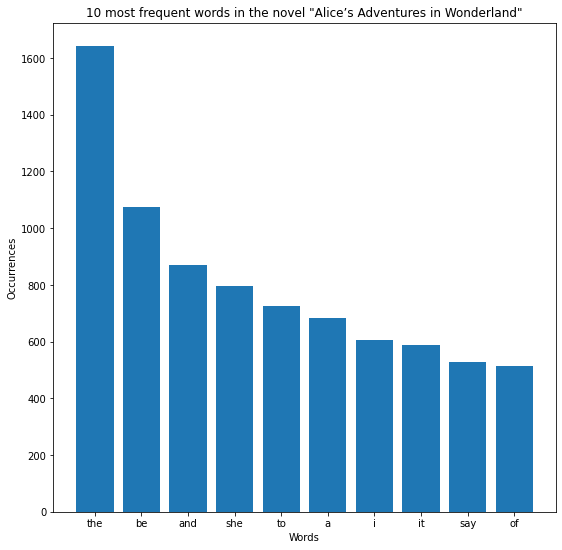

In [18]:
_top10_words = _frequence[:10] 
_x_axis, _y_axis = _get_freq_axis(_top10_words)
_draw_bar(_x_axis, _y_axis, "10 most frequent words in the novel \"Alice’s Adventures in Wonderland\"")

# 37. Top-ten words co-occurring with ‘Alice’

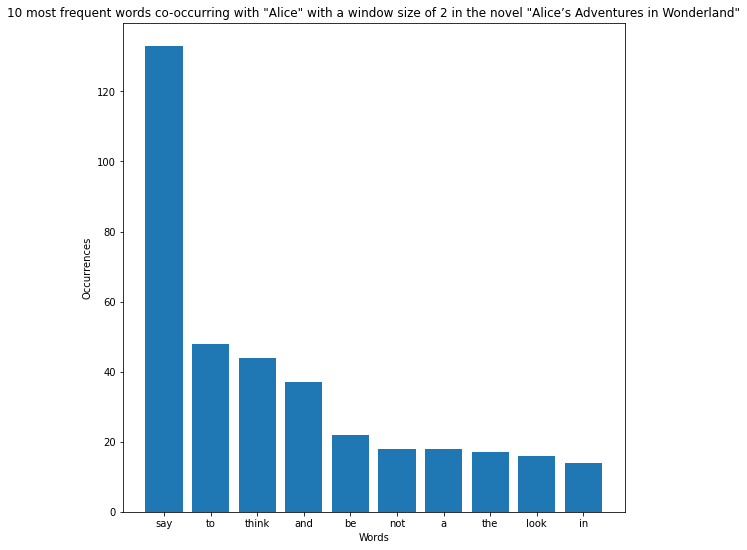

In [10]:
def _update_frequence(frequence: Counter, word: dict) -> None:
    if word["pos"] not in ("SYM", "PUNCT"):
        frequence[word["lemma"]] += 1

def _get_cooccurrence(target: str = "alice", WINDOW_SIZE: int = 1, sentences: list = _sentences) -> Counter:
    frequence = Counter()
    SENTENCES_LEN = len(sentences)
    for s_index in range(SENTENCES_LEN):
        if sentences[s_index]["lemma"] == target:
            for w_index in range(1, WINDOW_SIZE+1):
                if s_index-w_index >= 0:
                    _update_frequence(frequence, sentences[s_index-w_index])
                if s_index+w_index < SENTENCES_LEN:
                    _update_frequence(frequence, sentences[s_index+w_index])
    return frequence

N = 2
_top10_alice = _get_cooccurrence(WINDOW_SIZE = N).most_common(10)
_x_axis, _y_axis = _get_freq_axis(_top10_alice)
_draw_bar(_x_axis, _y_axis, f"10 most frequent words co-occurring with \"Alice\" with a window size of {N} in the novel \"Alice’s Adventures in Wonderland\"")


# 38. Histogram

<class 'matplotlib.axes._subplots.AxesSubplot'>


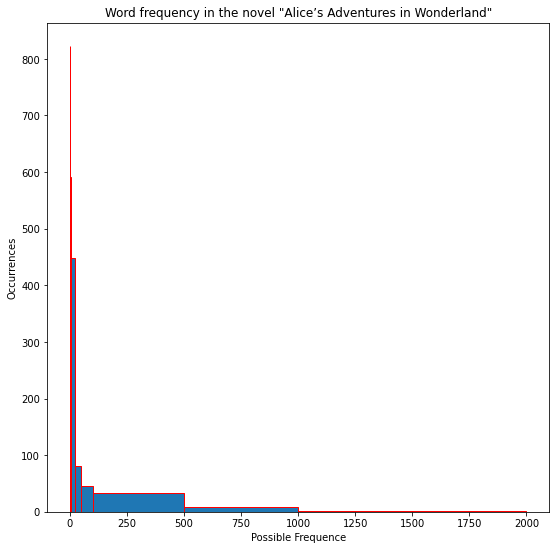

In [20]:
def _draw_hist(x: list, y: list, title: str) -> None:
    ax = _set_figure(title)
    ax.hist(x, y, edgecolor="red")
    ax.set_xlabel("Possible Frequence")
    plt.show()

_x_axis = []

for freq in _frequence:
    _x_axis.append(freq[1])

_y_axis = [1, 2, 5, 25, 50, 100, 500, 1000, 2000]
_draw_hist(_x_axis, _y_axis, f"Word frequency in the novel \"Alice’s Adventures in Wonderland\"")

# 39. Zipf’s law

Plot a log-log graph with the x-axis being rank order and the y-axis being frequency.

<class 'matplotlib.axes._subplots.AxesSubplot'>


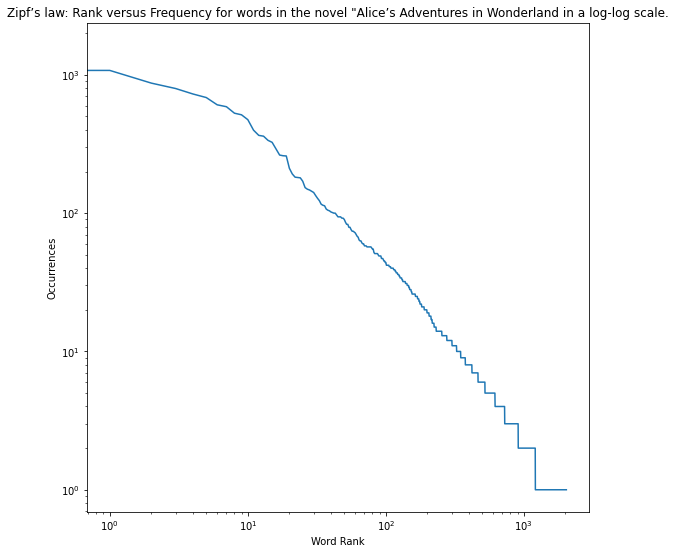

In [22]:
def _draw_plot(x: list, y: list, title: str) -> None:
    ax = _set_figure(title)
    ax.plot(x, y)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel("Word Rank")
    plt.show()

_x_axis, _y_axis = _get_freq_axis(_frequence)
_draw_plot(_x_axis, _y_axis, "Zipf’s law: Rank versus Frequency for words in the novel \"Alice’s Adventures in Wonderland in a log-log scale.")